In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float, BigInteger
from sqlalchemy.ext.declarative import declarative_base
warnings.filterwarnings("ignore")

# <font color="red">Atención!!!</font>

###### La siguiente variable hay que establecerla en False si no tienes el csv creado. Así es como lo creamos

In [ ]:
CSVCreated = True

------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def createCsvFromDatabase() -> bool:
    try:
        #conection to sqlite database
        conn = sqlite3.connect("data.sqlite")

        #cursor to run SQL queries
        cursor = conn.cursor()

        #getting all the tables in database
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        databaseTables = cursor.fetchall()
        print("Tablas database:\n",databaseTables)

        #getting all tables info -- cannot use join table cause it is a result of the rest
        happiness = pd.read_sql_query("SELECT * FROM happiness", conn)
        gini = pd.read_sql_query("SELECT * FROM gini", conn)
        demographic = pd.read_sql_query("SELECT * FROM demographic", conn)
        geo = pd.read_sql_query("SELECT * FROM geo", conn)
        explain = pd.read_sql_query("SELECT * FROM explain", conn)
        #merge dataframes using 'id' column to create happiness and its own parameters (about contries and gini indicator)
        dfMerged = happiness.merge(gini, on=["country"], how="inner").merge(demographic, on=["country"], how="inner")

        #saving data as two different CSVs for better working
        dfMerged.to_csv('happinessTotal.csv', index = False)
        explain.to_csv('countriesParameters.csv', index = False)

        #Closing database connection
        cursor.close()
        conn.close()

        print("\n---- Dataframes Creados ----")
        return True

    except Exception as e:
        print(f"Error cargando Database o con sus datos. Revisar : {str(e)}")
        return False

In [ ]:
if not CSVCreated:
    result = createCsvFromDatabase()
    CSVCreated = True
    if not result:
        print("Necesitas archivo de BBDD data.sqlite. Está en el drive del TFM")

In [ ]:
#opening the CSV created about happiness
dfH = pd.read_csv('happinessTotal.csv')
#opening the CSV created parameters per country
dfP = pd.read_csv('countriesParameters.csv')

In [ ]:
#cleaning non valid columns
dfH.drop(['id_x', 'year_x', 'id_y', 'country_code', 'year_y','lat_y', 'lon_y' ,'id', 'region_id', 'lat', 'lon'], axis=1, inplace=True)
#cleaning NaN or null values from dataframe
dfH = dfH.dropna()
# Crear una columna de ID
dfH['ID'] = range(1, len(dfH) + 1)
#seeing dataset metrics
dfH.info()
dfH.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     128 non-null    object 
 1   happiness   128 non-null    float64
 2   lat_x       128 non-null    float64
 3   lon_x       128 non-null    float64
 4   gini        128 non-null    float64
 5   year        128 non-null    int64  
 6   gdp         128 non-null    float64
 7   population  128 non-null    float64
 8   ID          128 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 9.1+ KB


,happiness,lat_x,lon_x,gini,year,gdp,population,ID
count,128.00000,128.000000,128.000000,128.000000,128.0,1.280000e+02,1.280000e+02,128.000000
mean,5.54550,21.491856,10.972372,38.275781,2018.0,5.452528e+11,4.796431e+07,64.500000
std,1.09851,25.627514,53.344232,8.696589,0.0,1.853723e+12,1.576478e+08,37.094474
min,3.33500,-38.416097,-106.346771,16.600000,2018.0,6.113708e+08,3.308150e+05,1.000000
25%,4.72125,6.036145,-8.229313,32.250000,2018.0,1.371912e+10,4.145015e+06,32.750000
50%,5.66500,20.800787,18.566955,36.350000,2018.0,4.852250e+10,1.053723e+07,64.500000
75%,6.27075,42.714979,34.977447,43.325000,2018.0,2.720152e+11,3.451197e+07,96.250000
max,7.85800,64.963051,138.252924,63.000000,2018.0,1.692030e+13,1.370000e+09,128.000000


In [ ]:
#dividimos en datos no útiles
dfHCountry = dfH.country
dfHFormatted = dfH.drop(['country','year', 'lat_x', 'lon_x'], axis=1)

In [ ]:
dfHFormatted

,happiness,gini,gdp,population,ID
0,5.004,29.0,1.347108e+10,2880703.0,1
1,5.043,27.6,1.960350e+11,40606052.0,2
2,3.795,42.7,1.030420e+11,25096150.0,3
3,5.793,42.4,4.475180e+11,42981515.0,4
4,5.062,32.5,1.150200e+10,2906220.0,5
...,...,...,...,...,...
123,6.372,39.7,4.836293e+10,3431552.0,124
124,6.205,35.3,6.246909e+10,29774500.0,125
125,5.296,34.8,1.641050e+11,86932500.0,126
126,4.041,57.1,2.703717e+10,14264756.0,127


    happiness  gini           gdp   population   ID  Cluster
0       5.004  29.0  1.347108e+10    2880703.0    1        0
1       5.043  27.6  1.960350e+11   40606052.0    2        0
2       3.795  42.7  1.030420e+11   25096150.0    3        1
3       5.793  42.4  4.475180e+11   42981515.0    4        1
4       5.062  32.5  1.150200e+10    2906220.0    5        0
..        ...   ...           ...          ...  ...      ...
95      5.869  40.1  2.843490e+11  103320222.0   96        0
96      6.201  31.8  5.721320e+11   37986412.0   97        0
97      5.920  35.5  2.317450e+11   10401062.0   98        0
98      6.151  28.3  2.002170e+11   19815481.0   99        0
99      3.561  50.4  8.805015e+09   11917508.0  100        1

[100 rows x 6 columns]


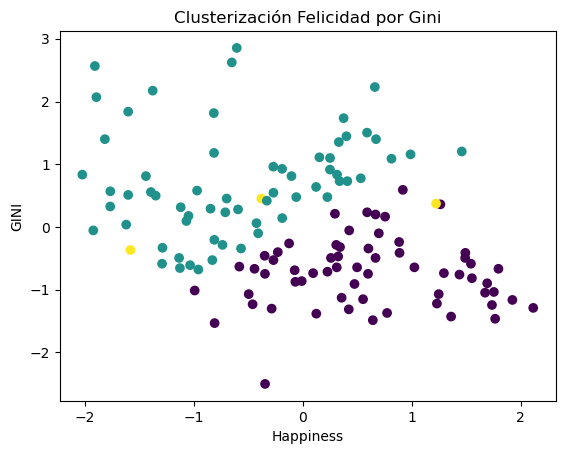

In [ ]:
# Crear un modelo K-Means con el número deseado de clústeres (n_clusters)
n_clusters = 3  # Puedes ajustar este número según tus necesidades
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Aplicar la normalización Min-Max a las características
scaler = StandardScaler()
normalized_features = scaler.fit_transform(dfHFormatted)

# Ajustar el modelo K-Means a los datos normalizados
kmeans.fit(normalized_features)

# Obtener las etiquetas de clústeres para cada punto de datos en tus datos
labels = kmeans.labels_
dfHFormatted['Cluster'] = labels

# Visualizar los resultados o realizar análisis adicional
print(dfHFormatted.head(100))  # Muestra el DataFrame con las etiquetas de clústeres

# También puedes realizar visualizaciones para explorar los clústeres
# Por ejemplo, un gráfico de dispersión 2D de dos de las características normalizadas
plt.scatter(normalized_features[:, 0], normalized_features[:, 1], c=dfHFormatted['Cluster'], cmap='viridis')
plt.xlabel('Happiness')
plt.ylabel('GINI')
plt.title(f'Clusterización Felicidad por Gini')
plt.show()



In [ ]:
results = dfHFormatted[['Cluster', 'ID']]
dfFinal = dfH.merge(results, on='ID', how='left')
dfFinal.drop(['lat_x', 'lon_x'], axis=1, inplace=True)
dfFinal = dfFinal.reindex(columns=["ID", "country", "happiness", "gini", "year", "gdp", "population", "Cluster"])
dfFinal.head()

,ID,country,happiness,gini,year,gdp,population,Cluster
0,1,Albania,5.004,29.0,2018,1.347108e+10,2880703.0,0
1,2,Algeria,5.043,27.6,2018,1.960350e+11,40606052.0,0
2,3,Angola,3.795,42.7,2018,1.030420e+11,25096150.0,1
3,4,Argentina,5.793,42.4,2018,4.475180e+11,42981515.0,1
4,5,Armenia,5.062,32.5,2018,1.150200e+10,2906220.0,0


In [ ]:
# Conexion BBDD
engine = create_engine('sqlite:///tu_basede_datos.db')

#insercción
dfFinal.to_sql('datos', con=engine, if_exists='replace', index=False)


Base = declarative_base()
class TuTabla(Base):
    __tablename__ = '[SOCIAL] Felicidad'  # Cambia esto por el nombre de la tabla que desees

    ID = Column(Integer, primary_key=True)
    country = Column(String)
    happiness = Column(Float)
    gini = Column(Float)
    year = Column(Integer)
    gdp = Column(Float)
    population = Column(BigInteger)
    Cluster = Column(Integer)

# Crea la tabla en la base de datos
Base.metadata.create_all(engine)

# Inserta los datos en la tabla
dfFinal.to_sql('[SOCIAL] Felicidad', con=engine, if_exists='replace', index=False)



128